In [41]:
# necessary libraries

import numpy as np
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization, PReLU
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras import regularizers
import torch
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras import initializers

import copy
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
import threading
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### text embeddings

In [43]:
import pickle
with open('../politifact/finalTrainEmbeddings.pkl', 'rb') as f:
    trainEmbeddings = pickle.load(f)
with open('../politifact/finalTestEmbeddings.pkl', 'rb') as f:
    testEmbeddings = pickle.load(f)

In [44]:
import json
with open('../imageDataset/politi/trainJson.json', 'r') as f:
    trainData = json.load(f)
with open('../imageDataset/politi/testJson.json', 'r') as f:
    testData = json.load(f)

In [45]:
for i in trainEmbeddings:
    trainEmbeddings[i] = [torch.mean(j[0], axis=1) for j in trainEmbeddings[i]]

In [46]:
for i in testEmbeddings:
    testEmbeddings[i] = [torch.mean(j[0], axis=1) for j in testEmbeddings[i]]

In [47]:
for i in testEmbeddings:
    temp = testEmbeddings[i]
    break

In [48]:
for i in trainEmbeddings:
    if len(trainEmbeddings[i]) >=50:
        trainEmbeddings[i] = trainEmbeddings[i][0:50]
    else:
        deficit = 50 - len(trainEmbeddings[i])
        for j in range(deficit):
            trainEmbeddings[i].append(torch.zeros((1,768), dtype=torch.float32, device='cuda:0'))
    temp = torch.empty(50,768, dtype=torch.float32, device='cuda:0')
    for j in range(len(trainEmbeddings[i])):
        temp[j][:] = trainEmbeddings[i][j]
    trainEmbeddings[i] = temp

### image embeddings

In [49]:
with open('politifact/train_vgg_poli.pickle', 'rb') as f:
    train_vgg_poli = pickle.load(f)
with open('politifact/test_vgg_poli.pickle', 'rb') as f:
    test_vgg_poli = pickle.load(f)

In [50]:
for i in testEmbeddings:
    if len(testEmbeddings[i]) >=50:
        testEmbeddings[i] = testEmbeddings[i][0:50]
    else:
        deficit = 50 - len(testEmbeddings[i])
        for j in range(deficit):
            testEmbeddings[i].append(torch.zeros((1,768), dtype=torch.float32, device='cuda:0'))
    temp = torch.empty(50,768, dtype=torch.float32, device='cuda:0')
    for j in range(len(testEmbeddings[i])):
        temp[j][:] = testEmbeddings[i][j]
    testEmbeddings[i] = temp

In [52]:
train_text = []
train_label = []
test_text = []
test_label = []
train_image = []
test_image = []
testEmbedOrder = []
testImageOrder = []

In [53]:
for i in train_vgg_poli:
    for j in trainData:
        if i.split('.jpg')[0] == trainData[j][-1]['Top_img']:
            train_text.append(trainEmbeddings[j])
            train_image.append(train_vgg_poli[trainData[j][-1]['Top_img'] + '.jpg'])
            train_label.append(trainData[j][0])

In [54]:
for i in test_vgg_poli:
    for j in testData:
        if i.split('.jpg')[0] == testData[j][-1]['Top_img']:
            test_text.append(testEmbeddings[j])
            test_image.append(test_vgg_poli[testData[j][-1]['Top_img'] + '.jpg'])
            test_label.append(testData[j][0])
            testEmbedOrder.append(j)
            testImageOrder.append(i)

In [55]:
len(train_text), len(train_image), len(train_label)

(381, 381, 381)

In [56]:
len(test_text), len(test_image), len(test_label), len(testEmbedOrder), len(testImageOrder)

(104, 104, 104, 104, 104)

In [57]:
realCount = 0
fakeCount = 0
for i in train_label:
    if i == 1:
        realCount += 1
    elif i == 0:
        fakeCount += 1

for i in test_label:
    if i == 1:
        realCount += 1
    elif i == 0:
        fakeCount += 1

print(realCount, fakeCount)

321 164


In [58]:
discreteTest = copy.deepcopy(test_label)

In [59]:
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)

In [60]:
train_text=[torch.Tensor.numpy(i.cpu()) for i in train_text]
test_text=[torch.Tensor.numpy(i.cpu()) for i in test_text]

In [61]:
train_text_matrix = np.ndarray(shape=(len(train_text), 50,768))

In [62]:
counter = 0
for i in train_text:
    train_text_matrix[counter][:][:] = i
    counter += 1

In [63]:
test_text_matrix = np.ndarray(shape=(len(test_text), 50,768))

In [64]:
counter = 0
for i in test_text:
    test_text_matrix[counter][:][:] = i
    counter += 1

In [65]:
test_text_matrix.shape

(104, 50, 768)

In [66]:
train_image[0].shape

(1, 4096)

In [67]:
train_image_matrix = np.ndarray(shape=(len(train_image), 4096,1))

In [68]:
counter = 0
for i in train_image:
    train_image_matrix[counter][:][:] = i.reshape(4096,1)
    counter += 1

In [69]:
test_image_matrix = np.ndarray(shape=(len(test_image), 4096,1))

In [70]:
counter = 0
for i in test_image:
    test_image_matrix[counter][:][:] = i.reshape(4096,1)
    counter += 1

In [71]:
train_image_matrix = train_image_matrix.reshape(381,4096)
test_image_matrix = test_image_matrix.reshape(104,4096)

## Inference

In [88]:
from keras.models import load_model
model = load_model('checkpoints_polity/dense_Text_model.hdf5')

In [89]:
predictions = model.predict(test_text_matrix)
predictions = predictions.argmax(axis=1)

In [90]:
data = []
for i in range(len(test_label)):
    data.append([testEmbedOrder[i],testEmbedOrder[i]testImageOrder[i],discreteTest[i],predictions[i]])

In [91]:
from pandas import DataFrame
df_text = DataFrame.from_records(data)
df_text.columns = ["Text", "image" ,"true", "predicted"]

In [103]:
df_text.loc[df_text['true'] < df_text['predicted']]

,Text,image,true,predicted
11,Statement from FDA Commissioner Scott Gottlieb...,2ZeChs9A2quWZsdZJKgl4geNCyWa6zeG.jpg,0,1
19,Singer Tina Turner: “This Thanksgiving Is The ...,6RT0ZrwHa1M1PKp2LJLtQ3vtNB2I04WP.jpg,0,1
23,9 celebrities who say they'll move to Canada i...,8AilY2mcf50mFUK3IAafUwowq4UAqJwF.jpg,0,1
42,Facebook 移動:\n\nこのメニューを開くには、 alt と / を同時に押してください,K0hYc0QUiOEge0AddBl5h7prDoD8J7lv.jpg,0,1
66,"The pro-Russia, pro-weed, pro-Assange GOP cong...",TeogG4pmmN0XcgQpVvKJ8zy5iFYCyvda.jpg,0,1
67,Who is affected by the government shutdown? Th...,aWaQJnj5j2H1bGabLgXI9iERn1nR7xxA.jpg,0,1
71,Debbie Wasserman Schultz Aide Arrested Trying ...,CDN8vxK3zSoEskVpkfvSpD392IL8iVK8.jpg,0,1
73,Trump Nation 移動:\n\nこのメニューを開くには、 alt と / を同時に押...,cIfs4dD4PuddiDvWjISPL3kWN9L5enLL.jpg,0,1
75,Puerto Rico Mayor Facing Fraud Charges Over Mi...,cnXac0ALxV3kUdcBiliAE8cr1SwtGPOI.jpg,0,1
78,FBI uncovered Russian bribery plot before Obam...,Cz7c5ggpRSzjFC3xiekzmUyW48ekDtOS.jpg,0,1


In [129]:
df_text.iloc[67]['Text']

"Who is affected by the government shutdown? Thousands of government workers are unsure whether or not they will be heading to work on Monday amid uncertainty about how long a government shutdown will last.\n\nUncertainty is the byproduct of a government shutdown, with its impact often hard to predict. However, clues exist in the last shutdown, which was in 2013.\n\nKey services will continue, and many agencies plan to use carryover funds to remain open for several days. But each day the shutdown lasts adds to the pressure on agencies, government employees and civilian contractors, as well as Americans who rely on various federal services.\n\nEmployees considered “essential” will still be required to report to work should the shutdown continue, while those in positions deemed “nonessential” will be barred from coming in.\n\nThe White House on Friday pledged to minimize the effects of the shutdown on the American people, with one official noting that the administration has urged governm

In [93]:
modelMM = load_model('checkpoints_polity/dense_MM_model.hdf5')

In [96]:
predictions2 = modelMM.predict([test_text_matrix, test_image_matrix])
predictions2 = predictions2.argmax(axis=1)

In [97]:
data2 = []
for i in range(len(test_label)):
    data2.append([testEmbedOrder[i],testImageOrder[i],discreteTest[i],predictions2[i]])
from pandas import DataFrame
df_MM = DataFrame.from_records(data2)

In [109]:
df_MM.iloc[67]

0    Who is affected by the government shutdown? Th...
1                 aWaQJnj5j2H1bGabLgXI9iERn1nR7xxA.jpg
2                                                    0
3                                                    0
Name: 67, dtype: object

[[24  5]
 [11 64]]


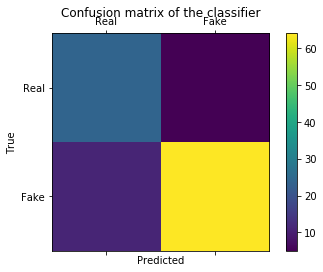

In [115]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = ['Real', 'Fake']
cm = confusion_matrix(discreteTest, predictions2)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [113]:
!pip uninstall matplotlib
!python -m pip install --upgrade pip
!pip install matplotlib

Uninstalling matplotlib-2.2.3:
  Would remove:
    /home/karmanya/.conda/envs/deepBert/lib/python3.7/site-packages/matplotlib-2.2.3-py3.7-nspkg.pth
    /home/karmanya/.conda/envs/deepBert/lib/python3.7/site-packages/matplotlib-2.2.3.dist-info/*
    /home/karmanya/.conda/envs/deepBert/lib/python3.7/site-packages/matplotlib/*
    /home/karmanya/.conda/envs/deepBert/lib/python3.7/site-packages/mpl_toolkits/axes_grid/*
    /home/karmanya/.conda/envs/deepBert/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/*
    /home/karmanya/.conda/envs/deepBert/lib/python3.7/site-packages/mpl_toolkits/axisartist/*
    /home/karmanya/.conda/envs/deepBert/lib/python3.7/site-packages/mpl_toolkits/mplot3d/*
    /home/karmanya/.conda/envs/deepBert/lib/python3.7/site-packages/mpl_toolkits/tests/*
    /home/karmanya/.conda/envs/deepBert/lib/python3.7/site-packages/pylab.py
Proceed (y/n)? ^C
ERROR: Operation cancelled by user
  Using cached https://files.pythonhosted.org/packages/30/db/9e38760b32e3e7f40cce46